<a href="https://colab.research.google.com/github/gabrielhozana/Time-Series-with-LSTM/blob/main/Time_Series_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Hold Energy Data - Time Series

The data was collected from my apartment unit in San Jose for one plus year. The data is collected with smart meters and shared by the energy company. This is time-series data by nature and can be used for various time-series Machine Learning experiments.

**Description of Data**

The data contains eight attributes.

* TYPE - This is an information column. The value is 'Electric usage' for all the observations.
* DATE - Date of electric consumption. There is no timestamp in this field.
* START TIME - Start time of the consumption.
* END TIME - End time of the consumption
* USAGE - Consumption in kWh
* UNITS - This column denotes measurement unit. It is kWh for all the observations.
* COST - Cost of consumption in $.
* NOTES - Mostly an empty column

# Load Dataset

In [ ]:
!pip install kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
# https://www.kaggle.com/jaganadhg/house-hold-energy-data
!kaggle datasets download -d jaganadhg/house-hold-energy-data

  0% 0.00/2.58M [00:00<?, ?B/s]
100% 2.58M/2.58M [00:00<00:00, 84.9MB/s]


In [ ]:
!unzip house-hold-energy-data

Archive:  house-hold-energy-data.zip
  inflating: D202.csv                
  inflating: D202.xlsx               


In [ ]:
import pandas as pd

df = pd.read_csv("D202.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


In [ ]:
pd.concat([df.head(),df.tail()])

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN
70367,Electric usage,10/24/2018,23:45,23:59,0.03,kWh,$0.01,NaN


In [ ]:
df.describe() 

,USAGE,NOTES
count,70368.000000,0.0
mean,0.121941,NaN
std,0.210507,NaN
min,0.000000,NaN
25%,0.030000,NaN
50%,0.050000,NaN
75%,0.120000,NaN
max,2.360000,NaN


In [ ]:
#mae
max = df['USAGE'].max()
min = df['USAGE'].min()
mae = 0.1*(max-min)

print("Max Value Usage: ", max)
print("Min Value Usage: ", min)
print("Mae: ", mae)

Max Value Usage:  2.36
Min Value Usage:  0.0
Mae:  0.236


In [ ]:
#convert data DATE to datetime
df["DATE_TIME"] = pd.to_datetime(df.DATE)
#using spesific columns / feature engineering
df = df[["DATE_TIME","USAGE"]]

In [ ]:
df.head()

,DATE_TIME,USAGE
0,2016-10-22,0.01
1,2016-10-22,0.01
2,2016-10-22,0.01
3,2016-10-22,0.01
4,2016-10-22,0.01


In [ ]:
df.isnull().sum()

DATE_TIME    0
USAGE        0
dtype: int64

# Visual

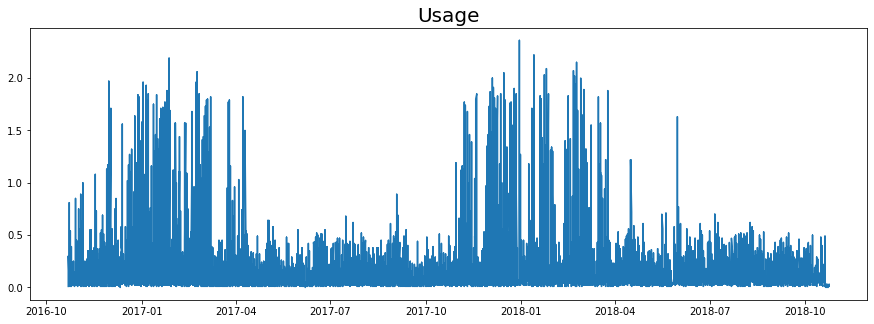

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
dates = df['DATE_TIME'].values
usage  = df['USAGE'].values
     
     
plt.figure(figsize=(15,5))
plt.plot(dates, usage)
plt.title('Usage',fontsize=20);

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(usage,dates, test_size=0.2)
print("Train shape: ", x_train.shape)
print("Test shape: ", x_test.shape)

Train shape:  (56294,)
Test shape:  (14074,)


# Window Data

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)
# atau bisa gunakan fungsi window dari keras
# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [ ]:
import tensorflow as tf
train_set = windowed_dataset(x_train, window_size=180, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(x_test, window_size=180, batch_size=100, shuffle_buffer=1000)

# Model

In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.LSTM(60),
                                    tf.keras.layers.Dense(64),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    ])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1 and logs.get('val_mae')<0.1):
      print("\nMae telah mencapai <10%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=5, validation_data=(test_set),verbose=2, callbacks=[callbacks])

Epoch 1/5
562/562 - 356s - loss: 0.0207 - mae: 0.1130 - val_loss: 0.0213 - val_mae: 0.1204
Epoch 2/5
562/562 - 353s - loss: 0.0206 - mae: 0.1128 - val_loss: 0.0216 - val_mae: 0.1294
Epoch 3/5
562/562 - 354s - loss: 0.0206 - mae: 0.1127 - val_loss: 0.0212 - val_mae: 0.1161
Epoch 4/5
562/562 - 359s - loss: 0.0206 - mae: 0.1126 - val_loss: 0.0212 - val_mae: 0.1116
Epoch 5/5
562/562 - 364s - loss: 0.0206 - mae: 0.1126 - val_loss: 0.0213 - val_mae: 0.1203


# Plot

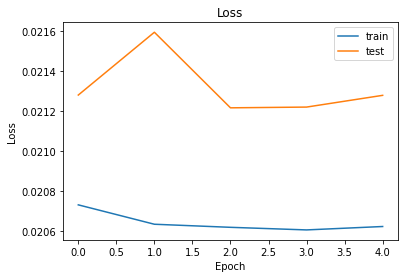

In [ ]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show();

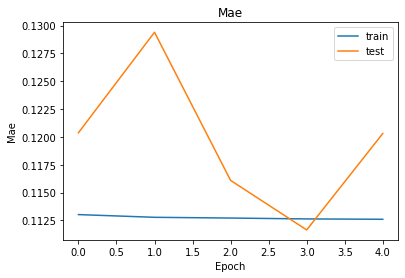

In [ ]:
plt.title('Mae')
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend()
plt.show();